# Day 4 - Graphene!

Today we are going to apply what we have learned and explore the electronic structure of graphene.

In this morning session,
- write script to perform scf calculation for graphene
    - calculate the band structure
    - calculate the density of states
- post processing!
    - plot results

## DFTK.jl

**Goal**: Write a script that take as input:
    - lattice,
    - atomic positions,
    - input parameters (Ecut, kgrid, etc.)

In [1]:
# load dependencies
using DFTK
using Plots

┌ Warning: Package DFTK does not have Plots in its dependencies:
│ - If you have DFTK checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DFTK
│ Loading Plots into DFTK from project dependency, future warnings for DFTK are suppressed.
└ @ nothing nothing:910


```julia
function run(lattice, atoms; extras)
    # setup of the DFT calculation

    # call self_consistent_field
    
    return scfres
end
```

In [146]:
# a simple solution
function run(lattice, atoms; Ecut=20, kgrid=[20, 20, 1], tol=1e-11, 
        smearing=Smearing.Gaussian(), temperature=0.0001)
    @info "Building DFT model"
    model = model_LDA(lattice, atoms, smearing=smearing, temperature=temperature)
    @info "Constructing plane-wave basis set"
    basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)
    @info "Solving Kohn-Sham equations self-consistently"
    scfres = self_consistent_field(basis; tol=tol)
    return basis, scfres
end;

In [138]:
a = 4.6111
c = 18.87
lattice = [[a -0.5*a 0]; [0 0.5*sqrt(3)*a 0]; [0 0 c]]

3×3 Array{Float64,2}:
 4.6111  -2.30555   0.0
 0.0      3.99333   0.0
 0.0      0.0      18.87

In [139]:
positions = [[1/3., 2/3., 0], [2/3., 1/3., 0]]

2-element Array{Array{Float64,1},1}:
 [0.3333333333333333, 0.6666666666666666, 0.0]
 [0.6666666666666666, 0.3333333333333333, 0.0]

In [140]:
C = ElementPsp(:C, psp=load_psp(:C, functional="lda"))
atoms = [C => [pos for pos in positions]]

1-element Array{Pair{ElementPsp,Array{Array{Float64,1},1}},1}:
 ElementPsp(6, :C, PspHgh(4, 0.34883045, [-8.5137711, 1.22843203, 0.0, 0.0], 1, [0.30455321, 0.2326773], [[9.52284179], Array{Float64}(undef,0,0)], "hgh/lda/c-q4.hgh", "C GTH-PADE-q4 GTH-LDA-q4")) => [[0.3333333333333333, 0.6666666666666666, 0.0], [0.6666666666666666, 0.3333333333333333, 0.0]]

In [147]:
basis, scfres = run(lattice, atoms);

┌ Info: Building DFT model
└ @ Main In[146]:4
┌ Info: Constructing plane-wave basis set
└ @ Main In[146]:6
┌ Info: Solving Kohn-Sham equations self-consistently
└ @ Main In[146]:8


n     Free energy       Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -11.28740504838         NaN   2.62e-01    3.4 
  2   -11.29632230814   -8.92e-03   3.78e-02    2.2 
  3   -11.29692681706   -6.05e-04   8.06e-03    2.5 
  4   -11.29696292787   -3.61e-05   7.79e-04    2.7 
  5   -11.29696369073   -7.63e-07   1.15e-04    3.7 
  6   -11.29696370702   -1.63e-08   1.26e-05    3.2 
  7   -11.29696370721   -1.90e-10   1.65e-06    3.7 
  8   -11.29696370721   -2.47e-12   1.50e-07    3.5 


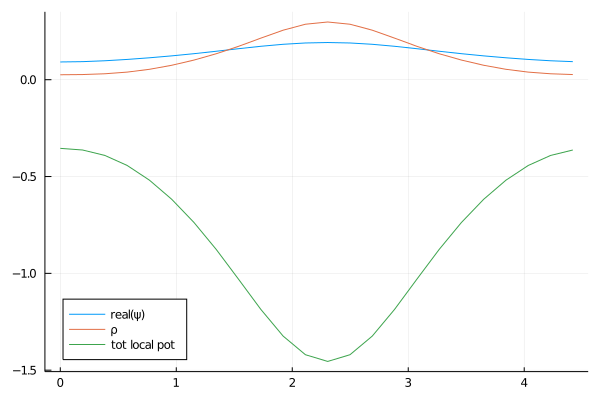

In [148]:
ρ = scfres.ρ.real[:, 1, 1, 1] 
ψ_fourier = scfres.ψ[1][:, 1];  
ψ = G_to_r(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));
tot_local_pot = DFTK.total_local_potential(scfres.ham)[:, 1, 1];
x = a * first.(DFTK.r_vectors(basis))[:, 1, 1]
p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, ρ, label="ρ")
plot!(p, x, tot_local_pot, label="tot local pot")
plot!(legend=:bottomleft)

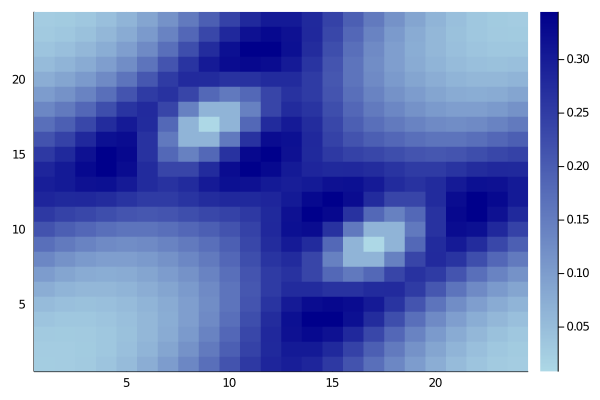

In [149]:
heatmap(scfres.ρ.real[:, :, 1, 1], c=:blues)

Computing bands along kpath:
       Γ -> M -> K -> Γ -> A -> L -> H -> A  and  L -> M  and  K -> H


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:21


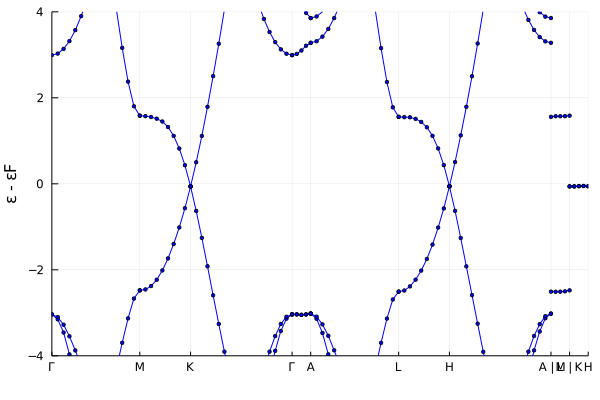

In [150]:
p = plot_bandstructure(scfres, kline_density=10)
plot!(p, xlabel = " ", ylabel="ε - εF", ylims=(-4, 4))

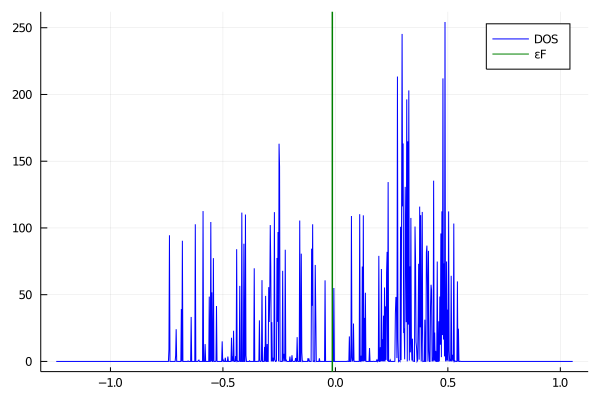

In [154]:
dos = plot_dos(scfres)